In [28]:
# !unzip -q "dataset.zip"

In [29]:
%load_ext autoreload
%autoreload 2

In [30]:
# root = ',/'

import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import torchvision as datasets
from PIL import Image
from sklearn.model_selection import KFold


%matplotlib inline

In [31]:
import torchvision
import torchvision
from torchvision import transforms

# from torchvision import datasets
from torchvision import datasets
# print(torchvision.__version__)
# print(datasets.ImageFolder)


# Create Dataset

In [32]:
data_dir = r'C:\Users\merug\Downloads\fall_detection\fall_detection_data'
batch_size = 32

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # convert 1 to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train dataset and dataloader
train_dataset = torchvision.datasets.ImageFolder(f'{data_dir}/train', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_sizes = len(train_dataset)
class_names = train_dataset.classes

# Validation dataset and dataloader
val_dataset = torchvision.datasets.ImageFolder(f'{data_dir}/val', transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

val_sizes = len(val_dataset)

In [33]:
class_names

['fall', 'no_fall']

In [34]:
train_sizes, val_sizes

(2300, 1297)

In [35]:
len(train_dataset)

2300

In [36]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create Model

In [37]:
class FDNet(nn.Module):
    def __init__(self, out_features=2):
        super(FDNet, self).__init__()
        mnet = models.mobilenet_v2(pretrained=True)
        for name, param in mnet.named_parameters():
            if("bn" not in name):
                param.requires_grad_(False)
            
        # Parameters of newly constructed modules have requires_grad=True by default
        in_features = mnet.classifier[1].in_features
        mnet.classifier = nn.Sequential(
                                nn.Dropout(p=0.2, inplace=False),
                                nn.Linear(in_features,500),
                                nn.ReLU(),
                                nn.Dropout(),
                                nn.Linear(500, out_features))
        self.mnet = mnet
        
    def forward(self, images):
        features = self.mnet(images)
        
        return features

## FDNet

In [38]:
# Initialize the model.
model = FDNet()

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FDNet(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), str

In [39]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
# Cross-validation
batch_size = 32
epochs = 20
k_folds = 5



# Train Model

In [40]:
def train(model, optimizer, loss_fn, train_loader, val_loader, start_epoch = 0, epochs=20, device="cpu"):
    model.to(device)# Lists to store losses and accuracy for plotting
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(start_epoch, start_epoch + epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()

        # Training phase
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        train_losses.append(training_loss)  # Store training loss
        
        # Validation phase
        model.eval()
        num_correct = 0 
        num_examples = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                loss = loss_fn(output, targets) 
                valid_loss += loss.data.item() * inputs.size(0)
                correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)  # Store validation loss
        
        accuracy = num_correct / num_examples
        accuracies.append(accuracy)  # Store accuracy

        print(f'Epoch: {epoch}, Training Loss: {training_loss:.2f}, Validation Loss: {valid_loss:.2f}, Accuracy: {accuracy:.2f}')

    return train_losses, val_losses, accuracies

In [41]:
# Initialize the model.
model = FDNet()

# Define the loss function.
criterion = nn.CrossEntropyLoss()

# Define the optimizer.
params = model.mnet.classifier.parameters()
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

epochs = 20

In [42]:
%%time
train(model, optimizer, criterion, train_dataloader, val_dataloader, epochs=epochs, device=device)
# train_losses, val_losses, accuracies = train(
#     model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device=device
# )

Epoch: 0, Training Loss: 0.47, Validation Loss: 0.36, Accuracy: 0.84
Epoch: 1, Training Loss: 0.37, Validation Loss: 0.31, Accuracy: 0.85
Epoch: 2, Training Loss: 0.32, Validation Loss: 0.28, Accuracy: 0.86
Epoch: 3, Training Loss: 0.29, Validation Loss: 0.25, Accuracy: 0.87
Epoch: 4, Training Loss: 0.28, Validation Loss: 0.23, Accuracy: 0.88
Epoch: 5, Training Loss: 0.25, Validation Loss: 0.22, Accuracy: 0.89
Epoch: 6, Training Loss: 0.24, Validation Loss: 0.23, Accuracy: 0.90
Epoch: 7, Training Loss: 0.22, Validation Loss: 0.21, Accuracy: 0.90
Epoch: 8, Training Loss: 0.21, Validation Loss: 0.20, Accuracy: 0.91
Epoch: 9, Training Loss: 0.21, Validation Loss: 0.20, Accuracy: 0.91
Epoch: 10, Training Loss: 0.21, Validation Loss: 0.19, Accuracy: 0.91
Epoch: 11, Training Loss: 0.21, Validation Loss: 0.18, Accuracy: 0.92
Epoch: 12, Training Loss: 0.19, Validation Loss: 0.19, Accuracy: 0.91
Epoch: 13, Training Loss: 0.19, Validation Loss: 0.17, Accuracy: 0.92
Epoch: 14, Training Loss: 0.19

([0.4680359349561774,
  0.36763511502224466,
  0.32266762375831604,
  0.291775101215943,
  0.2767354523876439,
  0.2527652262086454,
  0.24459596918976825,
  0.22452192220998846,
  0.20997976163159246,
  0.21454330159270246,
  0.20567911855552506,
  0.20669168845466945,
  0.1949058208776557,
  0.18601890639118526,
  0.18618990841119185,
  0.18819063336952874,
  0.18237714488869128,
  0.17769852145858434,
  0.17846857577562333,
  0.17901603232259336],
 [0.35799010899908834,
  0.31108183644097315,
  0.27804010806055185,
  0.2483437703656709,
  0.23217767023796657,
  0.22443926850809165,
  0.2266939898454509,
  0.20871479718808772,
  0.19993734263808524,
  0.19882273375585893,
  0.1877208237773929,
  0.18144523517538147,
  0.18835669965896132,
  0.17279931284780214,
  0.17285117057188715,
  0.17403051673751338,
  0.18030211719653427,
  0.19348606537042348,
  0.17049706268426584,
  0.16773503484691255],
 [0.8419429452582884,
  0.8504240555127217,
  0.8619892058596762,
  0.8704703161141095,

In [43]:
train_losses, val_losses, accuracies = train(
    model, optimizer, criterion, train_dataloader, val_dataloader, epochs=20, device=device
)

Epoch: 0, Training Loss: 0.17, Validation Loss: 0.16, Accuracy: 0.92
Epoch: 1, Training Loss: 0.16, Validation Loss: 0.16, Accuracy: 0.92
Epoch: 2, Training Loss: 0.18, Validation Loss: 0.17, Accuracy: 0.92
Epoch: 3, Training Loss: 0.16, Validation Loss: 0.17, Accuracy: 0.92
Epoch: 4, Training Loss: 0.17, Validation Loss: 0.17, Accuracy: 0.93
Epoch: 5, Training Loss: 0.16, Validation Loss: 0.18, Accuracy: 0.92
Epoch: 6, Training Loss: 0.17, Validation Loss: 0.19, Accuracy: 0.92
Epoch: 7, Training Loss: 0.17, Validation Loss: 0.16, Accuracy: 0.93
Epoch: 8, Training Loss: 0.15, Validation Loss: 0.16, Accuracy: 0.93
Epoch: 9, Training Loss: 0.15, Validation Loss: 0.17, Accuracy: 0.93
Epoch: 10, Training Loss: 0.16, Validation Loss: 0.15, Accuracy: 0.93
Epoch: 11, Training Loss: 0.15, Validation Loss: 0.16, Accuracy: 0.93
Epoch: 12, Training Loss: 0.15, Validation Loss: 0.16, Accuracy: 0.93
Epoch: 13, Training Loss: 0.15, Validation Loss: 0.15, Accuracy: 0.93
Epoch: 14, Training Loss: 0.14

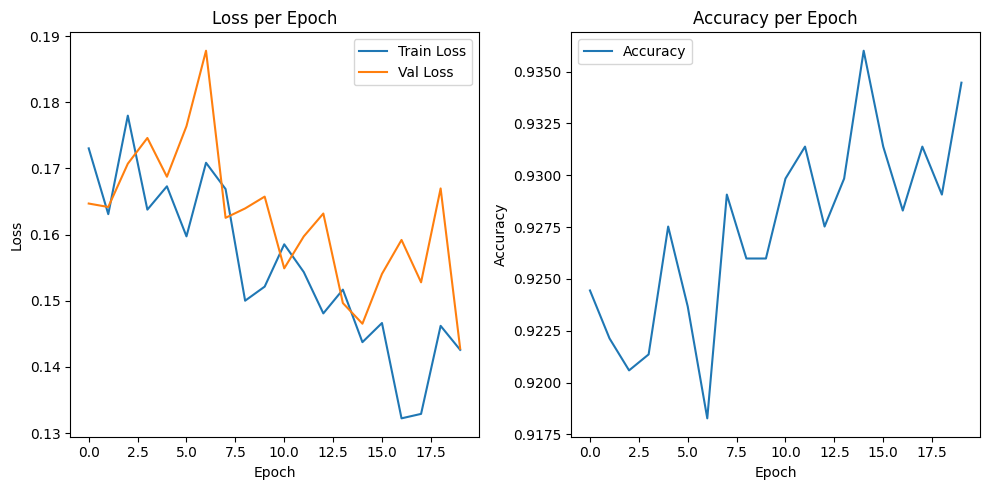

In [44]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

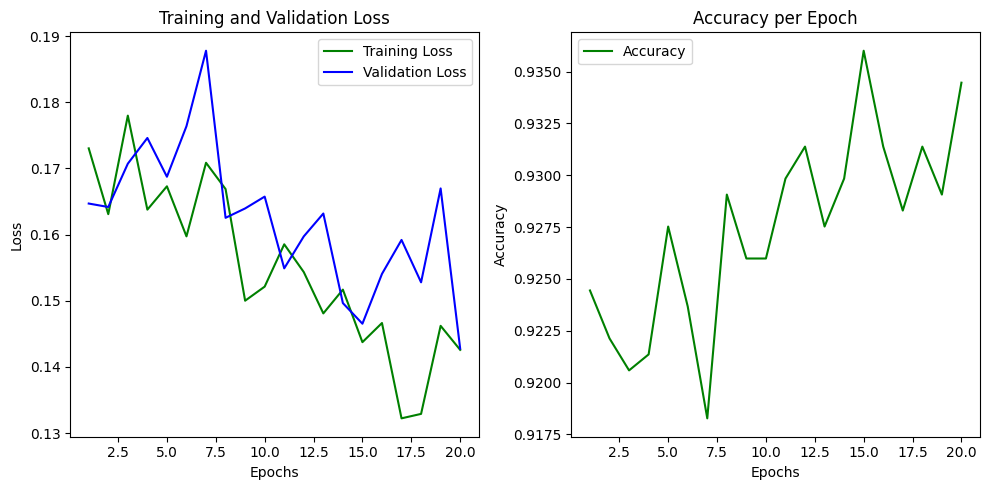

In [45]:
import matplotlib.pyplot as plt

# Assuming train_losses, val_losses, and accuracies are lists returned from your train function
epochs = range(1, len(train_losses) + 1)  # Adjust epoch range based on the length of your data

# Plot training and validation loss
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'g', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
# Then save the model
os.makedirs(f'train_model', exist_ok=True)  # Correct path handling
PATH = 'train_model/fdnet.pt'
torch.save(model.state_dict(), PATH)

# Evaluation

In [47]:
# Test dataset and dataloader
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

test_sizes = len(test_dataset)

In [48]:
test_sizes

1363

In [49]:
outputs_np = np.empty((0), dtype=int)
targets_np = np.empty((0), dtype=int)

model.eval()
num_correct = 0 
num_examples = 0
for batch in test_dataloader:
    inputs, targets = batch
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
    targets = targets.to(device)
    correct = torch.eq(outputs, targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
    
    outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
    targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

print(f'Accuracy: {num_correct / num_examples:.2f}')
print(num_correct, num_examples)


Accuracy: 0.93
1266 1363


In [50]:
# Set the number of epochs (integer)
epochs = 20  # or whatever number you want to train for

# KFold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')

    # Create data loaders for current fold
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    # Train and validate the model
    train_losses, val_losses, accuracies = train(
        model, optimizer, criterion, train_loader, val_loader, epochs=epochs, device=device
    )


Fold 1/5
Epoch: 0, Training Loss: 0.12, Validation Loss: 0.02, Accuracy: 0.98
Epoch: 1, Training Loss: 0.12, Validation Loss: 0.02, Accuracy: 0.97
Epoch: 2, Training Loss: 0.11, Validation Loss: 0.02, Accuracy: 0.98
Epoch: 3, Training Loss: 0.12, Validation Loss: 0.02, Accuracy: 0.98
Epoch: 4, Training Loss: 0.13, Validation Loss: 0.02, Accuracy: 0.98
Epoch: 5, Training Loss: 0.11, Validation Loss: 0.02, Accuracy: 0.98
Epoch: 6, Training Loss: 0.11, Validation Loss: 0.02, Accuracy: 0.96
Epoch: 7, Training Loss: 0.12, Validation Loss: 0.02, Accuracy: 0.97
Epoch: 8, Training Loss: 0.10, Validation Loss: 0.02, Accuracy: 0.97
Epoch: 9, Training Loss: 0.11, Validation Loss: 0.01, Accuracy: 0.98
Epoch: 10, Training Loss: 0.11, Validation Loss: 0.02, Accuracy: 0.96
Epoch: 11, Training Loss: 0.11, Validation Loss: 0.02, Accuracy: 0.97
Epoch: 12, Training Loss: 0.11, Validation Loss: 0.02, Accuracy: 0.97
Epoch: 13, Training Loss: 0.11, Validation Loss: 0.02, Accuracy: 0.97
Epoch: 14, Training L

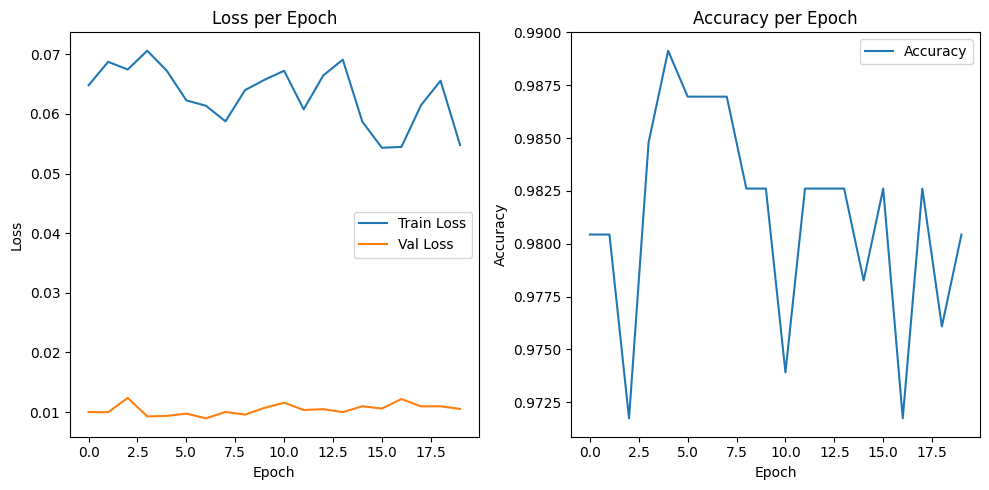

In [51]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Confusion Matrix

In [52]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(targets_np, outputs_np)

cf

array([[ 156,   55],
       [  42, 1110]], dtype=int64)

In [53]:
tn, fp, fn, tp = cf.ravel()

tn, fp, fn, tp

(156, 55, 42, 1110)

cross validation 

Testing model with video file

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchvision import transforms
from PIL import Image
import numpy as np

from torchvision import models, datasets, transforms

In [55]:
# Define the FDNet class (same as the one used for training)
class FDNet(nn.Module):
    def __init__(self, out_features=2):
        super(FDNet, self).__init__()
        mnet = models.mobilenet_v2(pretrained=True)
        for name, param in mnet.named_parameters():
            if "bn" not in name:
                param.requires_grad_(False)
        
        in_features = mnet.classifier[1].in_features
        mnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features, 500),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(500, out_features)
        )
        self.mnet = mnet
        
    def forward(self, images):
        features = self.mnet(images)
        return features

In [56]:
# Load the model
model = FDNet()
model_path = 'train_model/fdnet.pt'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\merug\AppData\Local\Temp\ipykernel_1948\1441959265.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github

FDNet(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), str

In [57]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FDNet(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), str

In [58]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [59]:
# Function to preprocess a video frame
def preprocess_frame(frame):
    # Convert to PIL Image and apply transformations
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(pil_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor


In [60]:
# Function to detect fall from a video file
def detect_fall_from_video(video_path, model):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or error in loading video.")
            break

        # Preprocess the frame
        frame_tensor = preprocess_frame(frame)

        # Pass the frame through the model
        with torch.no_grad():  # Disable gradient calculation for faster inference
            output = model(frame_tensor)
            prediction = torch.argmax(F.softmax(output, dim=1), dim=1).item()

        # Show the result on the frame
        if prediction == 0:
            label = "Fall Detected"
            color = (0, 0, 255)  # Red
        else:
            label = "No Fall"
            color = (0, 255, 0)  # Green
        
        # Display the label on the frame
        cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        cv2.imshow('Fall Detection', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release video capture and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

In [61]:
# Path to the AVI video file
video_path = r'C:\Users\merug\Downloads\fall_detection\datasets\FDD\Lecture_room\Lecture_room\video (27).avi'

# Run fall detection on the video
detect_fall_from_video(video_path, model)

End of video or error in loading video.


In [62]:
from sklearn.metrics import precision_score
precision = precision_score(targets_np, outputs_np)
print(f'Precision: {precision:.4f}')


Precision: 0.9528


In [63]:
from sklearn.metrics import recall_score
recall = recall_score(targets_np, outputs_np)
print(f'Recall: {recall:.4f}')


Recall: 0.9635


In [64]:
from sklearn.metrics import f1_score
f1 = f1_score(targets_np, outputs_np)
print(f'F1-Score: {f1:.4f}')


F1-Score: 0.9581


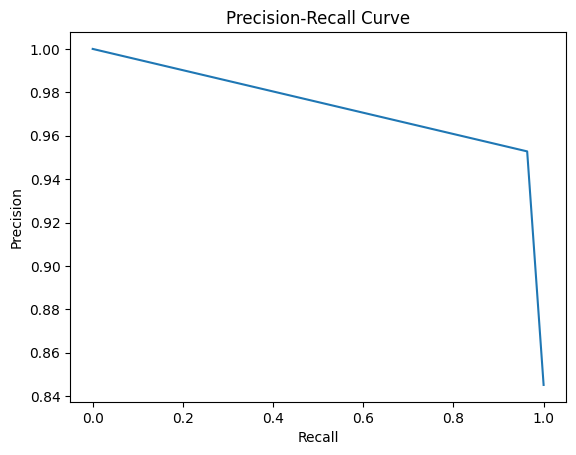

In [65]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(targets_np, outputs_np)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import imageio

# Define the FDNet class (same as the one used for training)
class FDNet(nn.Module):
    def __init__(self, out_features=2):
        super(FDNet, self).__init__()
        mnet = models.mobilenet_v2(pretrained=True)
        for name, param in mnet.named_parameters():
            if "bn" not in name:
                param.requires_grad_(False)
        
        in_features = mnet.classifier[1].in_features
        mnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features, 500),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(500, out_features)
        )
        self.mnet = mnet
        
    def forward(self, images):
        features = self.mnet(images)
        return features

# Load the model
model = FDNet()
model_path = 'train_model/fdnet.pt'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess a video frame
def preprocess_frame(frame):
    # Convert to PIL Image and apply transformations
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(pil_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor

# Function to detect fall from a video file and save as GIF and MP4
def detect_fall_from_video(video_path, model, output_gif_path, output_mp4_path):
    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    # Set up the video writer for MP4
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out_video = cv2.VideoWriter(output_mp4_path, fourcc, fps, (width, height))
    
    # List to store frames for the GIF
    gif_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or error in loading video.")
            break

        # Preprocess the frame
        frame_tensor = preprocess_frame(frame)

        # Pass the frame through the model
        with torch.no_grad():  # Disable gradient calculation for faster inference
            output = model(frame_tensor)
            prediction = torch.argmax(F.softmax(output, dim=1), dim=1).item()

        # Show the result on the frame
        if prediction == 0:
            label = "Fall Detected"
            color = (0, 0, 255)  # Red
        else:
            label = "No Fall"
            color = (0, 255, 0)  # Green
        
        # Display the label on the frame
        cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

        # Save the frame to the MP4 file
        out_video.write(frame)

        # Convert frame to RGB for the GIF
        gif_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gif_frames.append(Image.fromarray(gif_frame))

        # Show the frame in a window (optional)
        cv2.imshow('Fall Detection', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release video capture and video writer
    cap.release()
    out_video.release()
    cv2.destroyAllWindows()

    # Save the GIF
    gif_frames[0].save(output_gif_path, save_all=True, append_images=gif_frames[1:], duration=int(1000/fps), loop=0)

# Path to the AVI video file
video_path = r'C:\Users\merug\Downloads\fall_detection\datasets\FDD\Office\Office\video (16).avi'

# Output paths for GIF and MP4 files
output_gif_path = 'fall_detection_output1.gif'
output_mp4_path = 'fall_detection_output1.mp4'

# Run fall detection on the video and save the output
detect_fall_from_video(video_path, model, output_gif_path, output_mp4_path)


C:\Users\merug\AppData\Local\Temp\ipykernel_1948\4253129657.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


End of video or error in loading video.
